Import dan Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

Load Dataset

In [2]:
final_csv = r"E:\DragonEye\dataset\features.csv"

# Baca langsung CSV final
df = pd.read_csv(final_csv)

print("Kolom tersedia:", df.columns)
df.head()

Kolom tersedia: Index(['filename', 'area_cm2', 'width_cm', 'height_cm', 'weight_est_g',
       'texture_score', 'hue_mean'],
      dtype='object')


,filename,area_cm2,width_cm,height_cm,weight_est_g,texture_score,hue_mean
0,AD_01.jpg,134.9231,14.832,12.274,563.156,0.045618,0.502567
1,AD_02.jpg,138.0154,13.429,13.729,578.025,0.043557,0.499815
2,AD_03.jpg,140.0751,14.100,12.609,587.956,0.044134,0.493940
3,AD_04.jpg,148.8717,15.203,13.138,630.615,0.045223,0.490435
4,AD_05.jpg,135.6495,14.709,14.250,566.645,0.046784,0.579397


Evaluasi Akurasi & Confusion Matrix

===== EVALUASI GRADE =====
Akurasi Grade: 0.42411642411642414

Classification Report Grade:
               precision    recall  f1-score   support

           A       0.61      0.62      0.62       202
           B       0.17      0.17      0.17       119
           C       0.37      0.36      0.37       160

    accuracy                           0.42       481
   macro avg       0.38      0.38      0.38       481
weighted avg       0.42      0.42      0.42       481



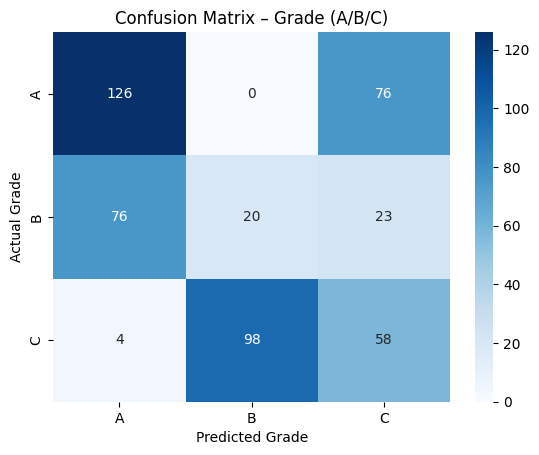


===== EVALUASI QUALITY =====
Akurasi Quality: 0.659043659043659

Classification Report Quality:
               precision    recall  f1-score   support

      defect       0.62      0.30      0.40       151
        good       0.51      0.84      0.64       156
      rotten       0.92      0.81      0.86       174

    accuracy                           0.66       481
   macro avg       0.69      0.65      0.63       481
weighted avg       0.70      0.66      0.64       481



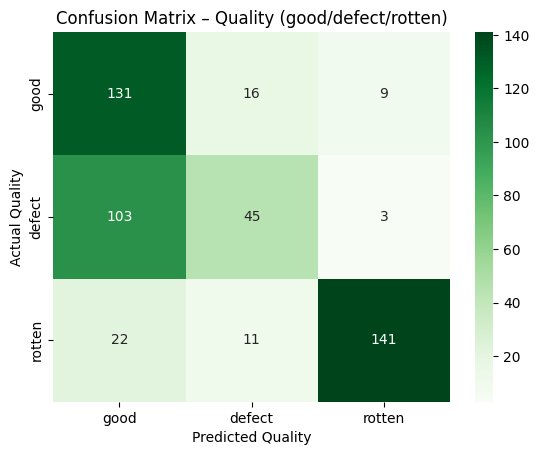

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

file_path = r"E:\DragonEye\dataset\graded_features.csv"
df = pd.read_csv(file_path)

# -----------------------------
# EXTRACT TRUE LABEL & PREDICTION
# -----------------------------
df["true_grade"] = df["label_asli"].apply(lambda x: x.split()[1])
df["true_quality"] = df["label_asli"].apply(lambda x: x.split()[2])

df["pred_grade"] = df["final_grade"].apply(lambda x: x.split()[0])
df["pred_quality"] = df["final_grade"].apply(lambda x: x.split()[1])

# -----------------------------
# 1. Evaluasi Grade (A/B/C)
# -----------------------------
print("===== EVALUASI GRADE =====")
print("Akurasi Grade:", accuracy_score(df['true_grade'], df['pred_grade']))
print("\nClassification Report Grade:\n",
      classification_report(df['true_grade'], df['pred_grade']))

cm_grade = confusion_matrix(df['true_grade'], df['pred_grade'], labels=['A','B','C'])

sns.heatmap(cm_grade, annot=True, fmt='d', cmap='Blues',
            xticklabels=['A','B','C'], yticklabels=['A','B','C'])
plt.title("Confusion Matrix – Grade (A/B/C)")
plt.xlabel("Predicted Grade")
plt.ylabel("Actual Grade")
plt.show()

# -----------------------------
# 2. Evaluasi Quality (good/defect/rotten)
# -----------------------------
print("\n===== EVALUASI QUALITY =====")
print("Akurasi Quality:", accuracy_score(df['true_quality'], df['pred_quality']))
print("\nClassification Report Quality:\n",
      classification_report(df['true_quality'], df['pred_quality']))

cm_quality = confusion_matrix(df['true_quality'], df['pred_quality'], 
                              labels=['good','defect','rotten'])

sns.heatmap(cm_quality, annot=True, fmt='d', cmap='Greens',
            xticklabels=['good','defect','rotten'], yticklabels=['good','defect','rotten'])
plt.title("Confusion Matrix – Quality (good/defect/rotten)")
plt.xlabel("Predicted Quality")
plt.ylabel("Actual Quality")
plt.show()


Distribusi Grade

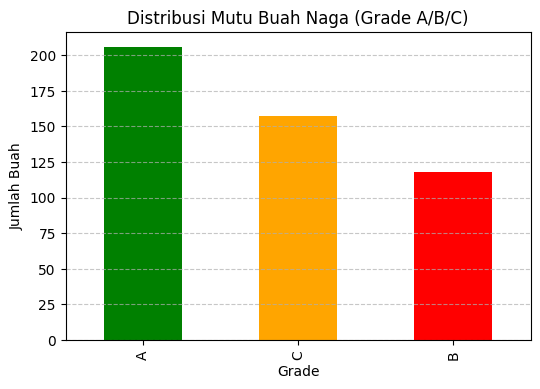

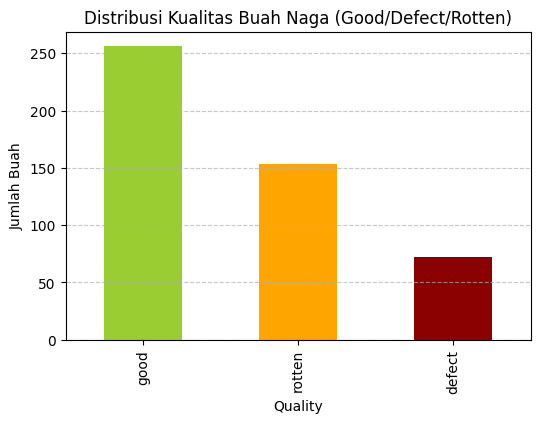

In [4]:
# Visualisasi distribusi grade berdasarkan grading (A/B/C)
plt.figure(figsize=(6, 4))
df['grade_by_weight'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Distribusi Mutu Buah Naga (Grade A/B/C)")
plt.xlabel("Grade")
plt.ylabel("Jumlah Buah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualisasi distribusi kualitas berdasarkan kualitas (Good/Defect/Rotten)
plt.figure(figsize=(6, 4))
df['fuzzy_grade_label'].value_counts().plot(kind='bar', color=['yellowgreen', 'orange', 'darkred'])
plt.title("Distribusi Kualitas Buah Naga (Good/Defect/Rotten)")
plt.xlabel("Quality")
plt.ylabel("Jumlah Buah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Visualisasi Sebaran Fitur

Index(['filename', 'area_cm2', 'width_cm', 'height_cm', 'weight_est_g',
       'texture_score', 'hue_mean', 'grade_by_weight', 'area_norm',
       'weight_norm', 'texture_norm', 'hue_norm', 'fuzzy_score',
       'fuzzy_grade_label', 'final_grade', 'label_asli', 'true_grade',
       'true_quality', 'pred_grade', 'pred_quality'],
      dtype='object')


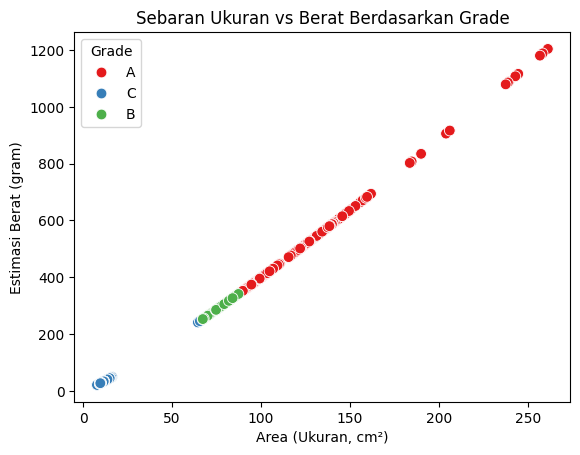

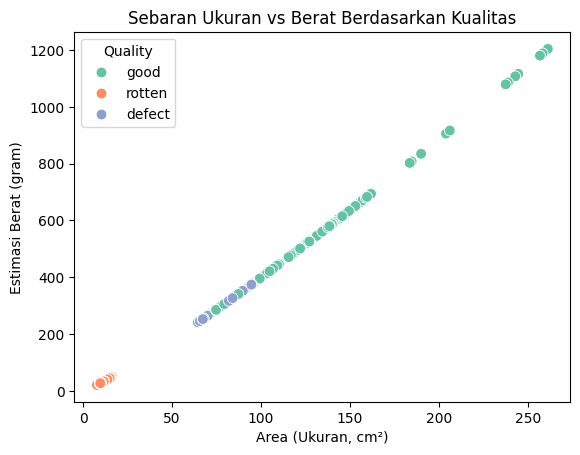

In [5]:
# Periksa kolom yang ada dalam DataFrame
print(df.columns)

# Scatter plot untuk ukuran dan berat berdasarkan grade
if 'area_cm2' in df.columns and 'weight_est_g' in df.columns:
    sns.scatterplot(data=df, x='area_cm2', y='weight_est_g', hue='grade_by_weight', palette='Set1', s=60)
    plt.title("Sebaran Ukuran vs Berat Berdasarkan Grade")
    plt.xlabel("Area (Ukuran, cm²)")
    plt.ylabel("Estimasi Berat (gram)")
    plt.legend(title="Grade")
    plt.show()
else:
    print("Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.")

# Scatter plot untuk ukuran dan berat berdasarkan kualitas (Good/Defect/Rotten)
if 'area_cm2' in df.columns and 'weight_est_g' in df.columns:
    sns.scatterplot(data=df, x='area_cm2', y='weight_est_g', hue='fuzzy_grade_label', palette='Set2', s=60)
    plt.title("Sebaran Ukuran vs Berat Berdasarkan Kualitas")
    plt.xlabel("Area (Ukuran, cm²)")
    plt.ylabel("Estimasi Berat (gram)")
    plt.legend(title="Quality")
    plt.show()
else:
    print("Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.")

Uji Hasil

In [6]:
import pandas as pd
import numpy as np
from ipywidgets import FileUpload, Output
from PIL import Image
import io
import matplotlib.pyplot as plt

print("DragonEye Evaluator Loaded")

# ---------------------------------------------------------
# 1. LOAD CSV
# ---------------------------------------------------------

csv_path = r"E:\DragonEye\dataset\graded_features.csv"
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

# pastikan kolom penting ada
for col in ["label_asli", "final_grade", "filename"]:
    if col not in df.columns:
        raise ValueError(f"Kolom '{col}' tidak ditemukan dalam CSV.")

# ---------------------------------------------------------
# Format label
# ---------------------------------------------------------

df["true_grade"] = df["label_asli"].apply(lambda x: x.split()[1].lower())
df["true_quality"] = df["label_asli"].apply(lambda x: x.split()[2].lower())

df["pred_grade"] = df["final_grade"].apply(lambda x: x.split()[0].lower())
df["pred_quality"] = df["final_grade"].apply(lambda x: x.split()[1].lower())

# ---------------------------------------------------------
# 2. FILE UPLOADER
# ---------------------------------------------------------

print("Silakan upload 1 file gambar untuk dianalisis:")

upload = FileUpload(accept='.jpg,.png,.jpeg', multiple=False)
display(upload)

out = Output()
display(out)

# ---------------------------------------------------------
# 3. EVENT HANDLER (NO LOOP)
# ---------------------------------------------------------

def handle_upload(change):
    with out:
        out.clear_output()

        # ---- FIX BUG: upload.value bisa tuple atau dict ----
        if isinstance(upload.value, dict):
            file_info = list(upload.value.values())[0]
        else:
            file_info = upload.value[0]

        image_bytes = file_info['content']
        image_name = file_info['name']

        # ----- tampilkan gambar kecil -----
        img = Image.open(io.BytesIO(image_bytes))
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.axis("off")
        plt.title("Gambar Input")
        plt.show()

        print("File:", image_name)

        # -----------------------------------------------------
        #  ANALISIS: cocokkan gambar input dgn CSV dataset
        # -----------------------------------------------------

        row = df[df["filename"] == image_name]

        if row.empty:
            print("Gambar tidak ditemukan di dataset. Tidak bisa dihitung akurasi.")
            upload.unobserve(handle_upload, 'value')
            return

        true_label = row.iloc[0]["label_asli"]
        pred_label = row.iloc[0]["final_grade"]

        true_grade = row.iloc[0]["true_grade"]
        pred_grade = row.iloc[0]["pred_grade"]

        true_quality = row.iloc[0]["true_quality"]
        pred_quality = row.iloc[0]["pred_quality"]

        # -----------------------------------------------------
        # AKURASI KHUSUS GAMBAR INI
        # -----------------------------------------------------

        grade_accuracy = 100 if true_grade == pred_grade else 0
        quality_accuracy = 100 if true_quality == pred_quality else 0

        # -----------------------------------------------------
        # TAMPILKAN HASIL
        # -----------------------------------------------------

        print("\nHASIL ANALISIS GAMBAR")
        print("Label Asli     :", true_label)
        print("Prediksi AI    :", pred_label)

        print("\nEvaluasi Prediksi:")
        print("Akurasi Grade   :", grade_accuracy, "%")
        print("Akurasi Quality :", quality_accuracy, "%")

        print("\nProgram selesai.")

    # hentikan listener agar tidak looping dan tidak hang
    upload.unobserve(handle_upload, 'value')


upload.observe(handle_upload, names='value')


DragonEye Evaluator Loaded
Silakan upload 1 file gambar untuk dianalisis:


FileUpload(value=(), accept='.jpg,.png,.jpeg', description='Upload')

Output()